In [16]:
offset = 2000 # year offset 

In [17]:
def biomass2LAI(x,sla,leaf_stem):
    '''
    Convert biomass to lai based on the specific leaf area.
    
    x: array of biomass values in g/m2
    sla: specific leaf area m2/kg c
    leaf_stem: ratio of leaf mass to stem mass
    '''
    x /= 1000. # g/m2 > kg/m2
    leaf = (x*leaf_stem) / (1.+leaf_stem) # compute leaf wet biomass
    lai = leaf * sla # convert leaf dry biomass to leaf area

    return lai

In [18]:
import gdal
import glob
from mpl_toolkits.basemap import Basemap
shp = '/Volumes/data/como_watershed_wgs84.shp'

def coord2dd(d,m,s): return d+(m/60.)+(s/60.)

In [19]:
files = glob.glob('./data/LANDIS_output/climate_change/watershed/*/*/TotalBiomass-*_como.tiff')

In [20]:
files = pd.DataFrame({'files':files})

In [21]:
years = []
tracks = []
scenarios = []
for fl in files.files:
    years.append(int(fl.split('-')[-1].split('_')[0]) + offset - 10)
    tracks.append(fl.split('/')[-3])
    scenarios.append(int(fl.split('_')[-2].split('/')[-2]))

files['year'] = years
files['track'] = tracks
files['scenario'] = scenarios

In [22]:
files.loc[files.year==1990]

,files,year,track,scenario
0,./data/LANDIS_output/climate_change/watershed/...,1990,PGW_less_P,1
12,./data/LANDIS_output/climate_change/watershed/...,1990,PGW_less_P,2
24,./data/LANDIS_output/climate_change/watershed/...,1990,PGW_less_P,5
36,./data/LANDIS_output/climate_change/watershed/...,1990,PGW_more_P,1
48,./data/LANDIS_output/climate_change/watershed/...,1990,PGW_more_P,2
60,./data/LANDIS_output/climate_change/watershed/...,1990,PGW_more_P,3


In [23]:
# bring in a raster on the basin to get the area
rastpth = './data/LAI_Boulder_crop.tif'
ds = gdal.Open(rastpth)
rast = np.array(ds.GetRasterBand(1).ReadAsArray(),dtype=float)
rast[rast<0] = np.NaN
mask = rast.copy()
mask[np.isnan(mask)==0] = 1

total_cells = np.nansum(mask)

In [33]:
def compute(df):
    sla = 9. # m^2 / kg
    leaf_stem = 0.0141
    cellsize = 50 # cell edge length in m
    fl = df.files

    ds = gdal.Open(fl)
    rast = np.array(ds.GetRasterBand(1).ReadAsArray(),dtype=float)
    rast[np.isnan(mask)] = np.NaN

    m,n = rast.shape
    lai = biomass2LAI(rast,sla,leaf_stem)
    lai[(lai==0) & (mask == 1)] = 0.5

    rast.shape = (m*n)
    lai.shape = (m*n)

    area = rast[(np.isnan(rast)==False) & (rast!=0)]
    area[:] = 1
    biomass = np.nansum(rast) / 1000. # compute total forest biomass for the basin, g > kg/m2
    area = np.sum(area)/total_cells # compute forested area
    lai = np.nanmean(lai) # compute basin mean LAI
    
    return (area,biomass,lai)

In [34]:
dat = files.copy()

In [35]:
res = dat.apply(compute,axis=1)

area,biomass,lai = zip(*res)

dat['area'] = area
dat['biomass'] = biomass
dat['lai'] = lai

del dat['files']

In [36]:
dat.area*=100.

In [37]:
dat.sort_values('year',ascending=True, inplace=True)

In [38]:
dat.head()

,year,track,scenario,area,biomass,lai
0,1990,PGW_less_P,1,71.838521,45.817759,2.929442
24,1990,PGW_less_P,5,71.838521,45.844150,2.931048
12,1990,PGW_less_P,2,71.838521,45.880491,2.933260
36,1990,PGW_more_P,1,71.838521,45.803746,2.928589
48,1990,PGW_more_P,2,71.838521,45.820057,2.929582


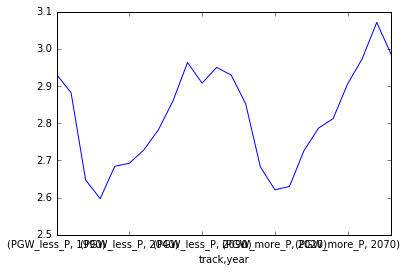

In [42]:
dat.groupby(['track','year']).mean().lai.plot()

In [46]:
dat.groupby(['track','year']).mean()

scenario       area    biomass       lai
track      year                                          
PGW_less_P 1990  2.666667  71.838521  45.847467  2.931250
           2000  2.666667  72.292477  45.081056  2.882334
           2010  2.666667  72.778859  41.266906  2.647759
           2020  2.666667  73.751621  40.518175  2.597324
           2030  2.666667  76.572633  42.180200  2.684376
           2040  2.666667  79.474708  42.554677  2.692658
           2050  2.666667  82.603761  43.400531  2.728494
           2060  2.666667  85.473411  44.524676  2.782566
           2070  2.666667  88.245785  46.025201  2.860031
           2080  2.666667  90.645266  47.920966  2.963417
           2090  2.666667  90.385863  46.989020  2.907992
           2100  2.666667  92.412451  47.851339  2.950343
PGW_more_P 1990  2.000000  71.838521  45.821139  2.929647
           2000  2.000000  72.260052  44.576003  2.851756
           2010  2.000000  74.578470  41.997527  2.683229
           2020  2.000000  75.794423  41.080162  2.621315
           2030  2.000000  78.258755  41.426102  2.630048
           2040  2.000000  81.355383  43.263322  2.726385
           2050  2.000000  84.484436  44.517163  2.787053
           2060  2.000000  87.094682  45.149925  2.812514
           2070  2.000000  89.623865  46.894100  2.906025
           2080  2.000000  91.974708  48.194471  2.973416
           2090  2.000000  93.547341  49.931223  3.071258
           2100  2.000000  94.520104  48.582475  2.984304

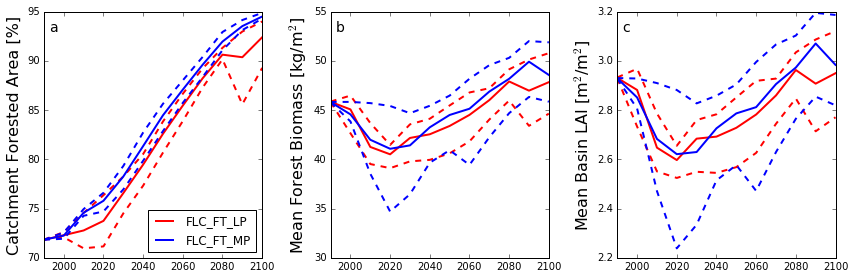

In [73]:
# generate a three panel figure
labfont = 16
textfont = 14
lpColor = 'r'
mpColor = 'b'

fig = plt.figure(figsize=(12,4))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

plt.sca(ax1)
var = 'area'
track = 'PGW_less_P'
c = lpColor
ls = '--'
plt.plot(dat.loc[dat.track==track].groupby('year').mean()[var],label='FLC_FT_LP',c=c,lw=lw)
plt.plot(dat.loc[dat.track==track].groupby('year').min()[var],c=c,ls=ls,lw=lw,label='')
plt.plot(dat.loc[dat.track==track].groupby('year').max()[var],c=c,ls=ls,lw=lw,label='')

track = 'PGW_more_P'
c = mpColor
plt.plot(dat.loc[dat.track==track].groupby('year').mean()[var],label='FLC_FT_MP',c=c,lw=lw)
plt.plot(dat.loc[dat.track==track].groupby('year').min()[var],c=c,ls=ls,label='',lw=lw)
plt.plot(dat.loc[dat.track==track].groupby('year').max()[var],c=c,ls=ls,label='',lw=lw)
plt.ylabel('Catchment Forested Area [%]',fontsize = labfont)
plt.legend(loc='lower right')
plt.xlim(1990,2100)
plt.text(1992.5,93,'a',fontsize=textfont)

plt.sca(ax2)
var = 'biomass'
track = 'PGW_less_P'
c = lpColor
ls = '--'
plt.plot(dat.loc[dat.track==track].groupby('year').mean()[var],label='FLC_FT_LP',c=c,lw=lw)
plt.plot(dat.loc[dat.track==track].groupby('year').min()[var],c=c,ls=ls,lw=lw,label='')
plt.plot(dat.loc[dat.track==track].groupby('year').max()[var],c=c,ls=ls,lw=lw,label='')

track = 'PGW_more_P'
c = mpColor
plt.plot(dat.loc[dat.track==track].groupby('year').mean()[var],label='FLC_FT_MP',c=c,lw=lw)
plt.plot(dat.loc[dat.track==track].groupby('year').min()[var],c=c,ls=ls,label='',lw=lw)
plt.plot(dat.loc[dat.track==track].groupby('year').max()[var],c=c,ls=ls,label='',lw=lw)
plt.ylabel('Mean Forest Biomass [kg/m$^2$]',fontsize = labfont)
plt.xlim(1990,2100)
plt.text(1992.5,53,'b',fontsize=textfont)

plt.sca(ax3)
var='lai'
track = 'PGW_less_P'
c = lpColor
ls = '--'
plt.plot(dat.loc[dat.track==track].groupby('year').mean()[var],label='FLC_FT_LP',c=c,lw=lw)
plt.plot(dat.loc[dat.track==track].groupby('year').min()[var],c=c,ls=ls,lw=lw,label='')
plt.plot(dat.loc[dat.track==track].groupby('year').max()[var],c=c,ls=ls,lw=lw,label='')

track = 'PGW_more_P'
c = mpColor
plt.plot(dat.loc[dat.track==track].groupby('year').mean()[var],label='FLC_FT_MP',c=c,lw=lw)
plt.plot(dat.loc[dat.track==track].groupby('year').min()[var],c=c,ls=ls,label='',lw=lw)
plt.plot(dat.loc[dat.track==track].groupby('year').max()[var],c=c,ls=ls,label='',lw=lw)
plt.ylabel('Mean Basin LAI [m$^2$/m$^2$]',fontsize = labfont)
plt.xlim(1990,2100)
plt.text(1992.5,3.12,'c',fontsize=textfont)
plt.tight_layout()

plt.savefig('./figures/LANIDS_forest_biomass_lai.png',dpi=300,bbox_inches='tight')
plt.savefig('./figures/LANIDS_forest_biomass_lai.pdf',bbox_inches='tight')

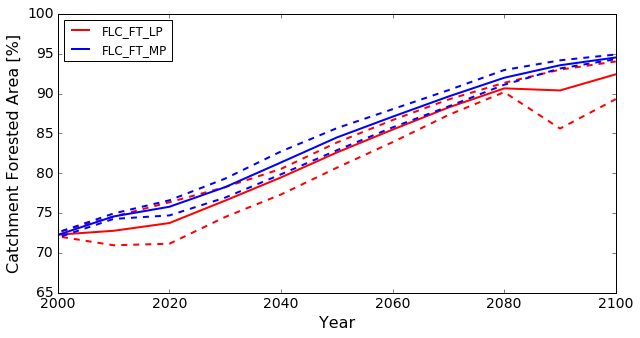

In [31]:
plt.figure(figsize=(10,5))
lw = 2
labelfont = 16

track = 'PGW_less_P'
c = 'r'
ls = '--'
plt.plot(dat.loc[dat.track==track].groupby('year').mean()['area'],label='FLC_FT_LP',c=c,lw=lw)
plt.plot(dat.loc[dat.track==track].groupby('year').min()['area'],c=c,ls=ls,lw=lw,label='')
plt.plot(dat.loc[dat.track==track].groupby('year').max()['area'],c=c,ls=ls,lw=lw,label='')

track = 'PGW_more_P'
c = 'b'
plt.plot(dat.loc[dat.track==track].groupby('year').mean()['area'],label='FLC_FT_MP',c=c,lw=lw)
plt.plot(dat.loc[dat.track==track].groupby('year').min()['area'],c=c,ls=ls,label='',lw=lw)
plt.plot(dat.loc[dat.track==track].groupby('year').max()['area'],c=c,ls=ls,label='',lw=lw)

plt.xlim(2000,2100)
plt.ylim(65,100)
plt.xlabel('Year', fontsize=labelfont)
plt.ylabel('Catchment Forested Area [%]', fontsize=labelfont)

ax = plt.gca()
[tick.label.set_fontsize(labelfont-2) for tick in ax.xaxis.get_major_ticks()];
[tick.label.set_fontsize(labelfont-2) for tick in ax.yaxis.get_major_ticks()];
plt.legend(loc='upper left')
plt.savefig('./figures/forested_area.png',dpi=300,bbox_inches='tight')
plt.savefig('./figures/forested_area.pdf',bbox_inches='tight')

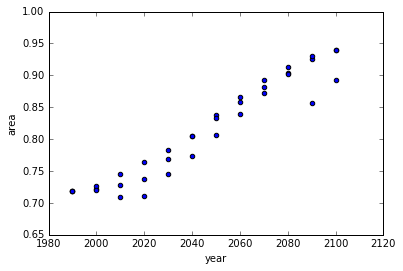

In [13]:
dat.loc[dat.track=='PGW_less_P'].plot.scatter('year','area')

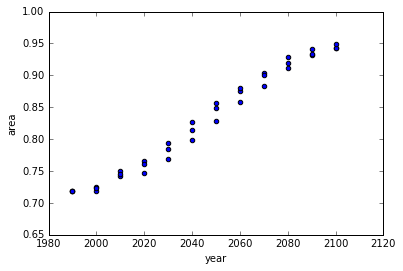

In [50]:
dat.loc[dat.track=='PGW_more_P'].plot.scatter('year','area')

In [51]:
dat = dat.loc[(dat.year==2000) | (dat.year==2050) | (dat.year==2100)]

In [52]:
dat

,year,track,scenario,area,biomass,lai
37,2000,PGW_more_P,1,0.725681,43.858784,2.943723
49,2000,PGW_more_P,2,0.719358,44.024202,2.960114
61,2000,PGW_more_P,3,0.722763,45.845024,3.067531
13,2000,PGW_less_P,2,0.721790,46.486565,3.107550
25,2000,PGW_less_P,5,0.726167,42.660121,2.870282
1,2000,PGW_less_P,1,0.720817,46.096483,3.084781
56,2050,PGW_more_P,2,0.856518,46.129994,2.951121
8,2050,PGW_less_P,1,0.838521,44.101842,2.845676
30,2050,PGW_less_P,5,0.832685,45.483739,2.935620
68,2050,PGW_more_P,3,0.849222,46.485353,2.980045


In [58]:
dat.groupby(by=['track','year']).mean().round(2)

scenario  area  biomass   lai
track      year                               
PGW_less_P 2000      2.67  0.72    45.08  3.02
           2050      2.67  0.83    43.40  2.82
           2100      2.67  0.92    47.85  2.99
PGW_more_P 2000      2.00  0.72    44.58  2.99
           2050      2.00  0.84    44.52  2.86
           2100      2.00  0.95    48.58  3.01

In [59]:
dat.groupby(by=['track','year']).min().round(2)

scenario  area  biomass   lai
track      year                               
PGW_less_P 2000         1  0.72    42.66  2.87
           2050         1  0.81    40.62  2.67
           2100         1  0.89    44.65  2.82
PGW_more_P 2000         1  0.72    43.86  2.94
           2050         1  0.83    40.94  2.66
           2100         1  0.94    45.87  2.85

In [57]:
dat.groupby(by=['track','year']).max().round(2)

scenario  area  biomass   lai
track      year                               
PGW_less_P 2000         5  0.73    46.49  3.11
           2050         5  0.84    45.48  2.94
           2100         5  0.94    50.80  3.15
PGW_more_P 2000         3  0.73    45.85  3.07
           2050         3  0.86    46.49  2.98
           2100         3  0.95    51.90  3.22

In [48]:
dat['mean_biomass'] = dat[['biomass1','biomass2','biomass3']].apply(np.mean,axis=1)
dat['mean_area'] = dat[['area1','area2','area3']].apply(np.mean,axis=1)
dat['mean_lai'] = dat[['lai1','lai2','lai3']].apply(np.mean,axis=1)

In [49]:
dat

,area1,area2,area3,biomass1,biomass2,biomass3,lai1,lai2,lai3,year,mean_biomass,mean_area,mean_lai
year,,,,,,,,,,,,,
1990.0,0.718385,0.718385,0.718385,45.817759,45.880491,45.844150,3.070249,3.074067,3.071855,1990.0,45.847467,0.718385,3.072057
2000.0,0.720817,0.721790,0.726167,46.096483,46.486565,42.660121,3.084781,3.107550,2.870282,2000.0,45.081056,0.722925,3.020871
2010.0,0.709630,0.728113,0.745623,39.529812,40.575397,43.695510,2.696297,2.741452,2.913844,2010.0,41.266906,0.727789,2.783864
2020.0,0.737354,0.711576,0.763619,41.475422,39.111476,40.967628,2.786990,2.668890,2.729819,2020.0,40.518175,0.737516,2.728566
2030.0,0.769455,0.745136,0.782588,43.180658,39.798163,43.561779,2.858676,2.677124,2.868740,2030.0,42.180200,0.765726,2.801513
2040.0,0.805447,0.773346,0.805447,43.572975,39.956136,44.134920,2.846561,2.658528,2.880763,2040.0,42.554677,0.794747,2.795284
2050.0,0.838521,0.806907,0.832685,44.101842,40.616013,45.483739,2.845676,2.665131,2.935620,2050.0,43.400531,0.826038,2.815476
2060.0,0.866732,0.839008,0.858463,44.938773,41.832162,46.803094,2.868405,2.707049,2.990142,2060.0,44.524676,0.854734,2.855199
2070.0,0.892510,0.873054,0.881809,47.233186,44.052348,46.790068,2.982273,2.808131,2.966003,2070.0,46.025201,0.882458,2.918802


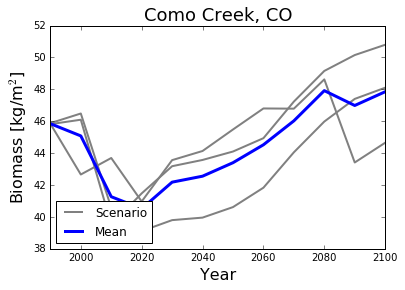

In [50]:
dat.biomass1.plot(lw=2,c='0.5',label = '')
dat.biomass2.plot(lw=2,c='0.5',label = '')
dat.biomass3.plot(lw=2,c='0.5',label='Scenario')
dat.mean_biomass.plot(lw=3,c='b',label='Mean')
plt.ylabel('Biomass [kg/m$^2$]',fontsize = 16)
plt.xlabel('Year', fontsize = 16)
plt.title('Como Creek, CO', fontsize=18)
plt.legend(loc='lower left')
plt.savefig('./figures/landis_biomass_timeseries.png',dpi=300,bbox_inches='tight')

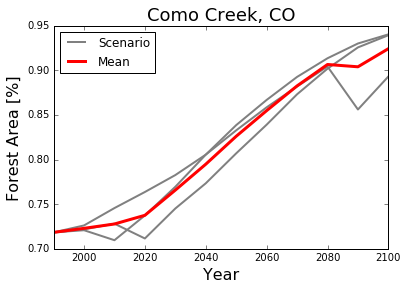

In [54]:
dat.area1.plot(lw=2,c='0.5',label = '')
dat.area2.plot(lw=2,c='0.5',label = '')
dat.area3.plot(lw=2,c='0.5',label='Scenario')
dat.mean_area.plot(lw=3,c='r',label='Mean')
plt.ylabel('Forest Area [%]',fontsize = 16)
plt.xlabel('Year', fontsize = 16)
plt.title('Como Creek, CO', fontsize=18)
plt.legend(loc = 'upper left')
plt.savefig('./figures/landis_forest_timeseries.png',dpi=300,bbox_inches='tight')

#### This is too high... total catchment area is ~5 km

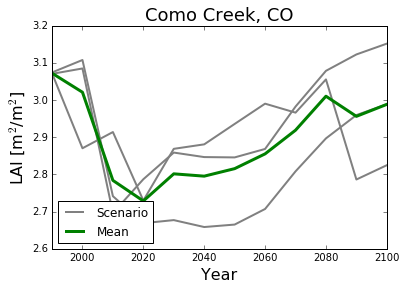

In [52]:
dat.lai1.plot(lw=2,c='0.5',label = '')
dat.lai2.plot(lw=2,c='0.5',label = '')
p1 = dat.lai3.plot(lw=2,c='0.5',label='Scenario')
p2 = dat.mean_lai.plot(lw=3,c='g',label='Mean')
plt.ylabel('LAI [m$^2$/m$^2$]',fontsize = 16)
plt.xlabel('Year', fontsize = 16)
plt.title('Como Creek, CO', fontsize=18)
plt.legend(loc='lower left')
plt.savefig('./figures/landis_lai_timeseries.png',dpi=300,bbox_inches='tight')

In [35]:
m = Basemap(llcrnrlon=-105.588055,llcrnrlat=40.028710,urcrnrlon=-105.537108,
            urcrnrlat=40.057246,resolution=None,projection='merc',
            lon_0=coord2dd(105,33,45.03),lat_0=coord2dd(40,2,4.58))

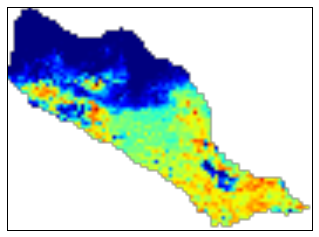

In [36]:
m.imshow(np.flipud(mask))

In [31]:
rastpth = './data/LANDIS_output/BDA+Fire_CC_1_2_110/output-leaf-biomass/TotalBiomass-110_como.tiff'

In [32]:
year = int(rastpth.split('-')[-1].split('_')[0])-10.

In [33]:
ds = gdal.Open(rastpth)
rast = np.array(ds.GetRasterBand(1).ReadAsArray(),dtype=float)
rast[rast==0] = np.NaN

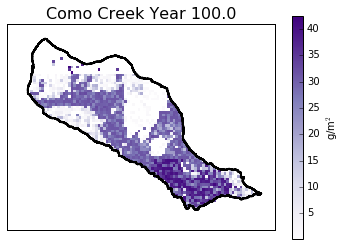

In [36]:
mp = m.imshow(np.flipud(rast),cmap='Purples',interpolation='none')
m.readshapefile(shp[0:-4],shp.split('/')[-1].split('.')[0], color='k', linewidth=2);
plt.xlim(-500,6000)
plt.ylim(-500,4500)
plt.colorbar(label='g/m$^2$')
plt.title('Como Creek Year %s'%year, fontsize=16)

In [ ]:
mp.set_data()

In [34]:
lai = biomass2LAI(rast,sla,leaf_stem)

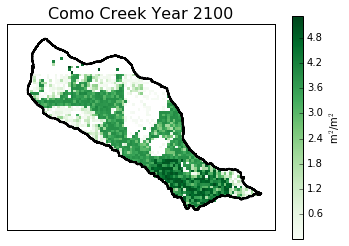

In [35]:
m.imshow(np.flipud(lai),cmap='Greens',interpolation='none')
m.readshapefile(shp[0:-4],shp.split('/')[-1].split('.')[0], color='k', linewidth=2);
plt.xlim(-500,6000)
plt.ylim(-500,4500)
plt.colorbar(label='m$^2$/m$^2$')
plt.title('Como Creek Year %s'%int(year+offset), fontsize=16)
plt.savefig('./figures/como_lai_map_%s.png'%(year+offset),dpi=300,bbox_inches='tight')